Прогнозирование временного ряда на примере решения задачи прогнозирования стоимости акций на московской межбанковской валютной биржи

Ключевые пункты:
* учет тренда и сезонности временного ряда стоимости 
* учет дополнительных параметров при прогнозировании - объем, уровни, волны
* учет возможной волатильности временного ряда
* анализ возможных рисков при соверешении операций с ценными бумагами
* использование разработанного инструмента для анализа различных акций и тд.

Методы для предсказания:
* ARIMA и т.д
* Преобразование Фурье
* Нейронные сети 
* Цепи Маркова


План диплома


Todo: 
* логарифмирование исходного ряда
* попробовать SARIMAX с дополнительными параметрами
* нейронные сети для анализа ряда 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import yfinance as yf
import warnings
import pmdarima as pm
# import statsmodels.graphics.tsaplots as sgt
# import eikon as ek # Требуется подписка
# import TA-Lib

from datetime import datetime
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from sklearn.linear_model import LinearRegression


# import statsmodels.api as sm

# import PyPortfolioOpt

import plotly.graph_objects as go

In [2]:
# pip install arch

In [3]:
# Получение котировок акций Apple
# data = ek.get_timeseries('AAPL.0', fields='*', 
#                          start_date='2018-10-18 16:00:00', 
#                          end_date='2018-10-18 17:00:00', 
#                          interval='tick')

# data.info()

# #1.0 Загрузка и анализ исходных даных
### #1.1 Загрузка данных и разбиение на train/test

In [4]:
# Часовой график
# apple_df_tmp = yf.download("AAPL", start="2022-01-03", interval='1h') #.to_csv('data/test.csv')
# apple_df_tmp.head()

In [2]:
apple_df = pd.read_csv('data/AAPL_20060101-20230131.csv', parse_dates=["Date"], index_col=["Date"])

# apple_df = yf.download("AAPL", start="2006-01-03", end="2023-01-30")
# apple_df = yf.download("AAPL", start="2006-01-03", interval='1d') #.to_csv('data/test.csv')

apple_df.head()

# apple_df = pd.read_csv('data/test.csv') #, parse_dates=["Date"], index_col=["Date"])

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.275651,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.282349,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.264388,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.322838,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.315227,675040800


#### Логарифмирование ряда

In [10]:
apple_df['Close'] = np.log(apple_df['Close'])

#### Разбиение на train/test

In [11]:
# Разбиение на тренировочную и тестовую выборки
train_df = apple_df.loc[:'2022-07-29'] #apple_df.iloc[:-3]
test_df = apple_df.loc['2022-08-01':] #apple_df.iloc[-3:]

train_df.shape, test_df.shape

((4172, 7), (126, 7))

### #1.2 Анализ ВР, построение графиков
##### *Годовые графики стоимости акций*

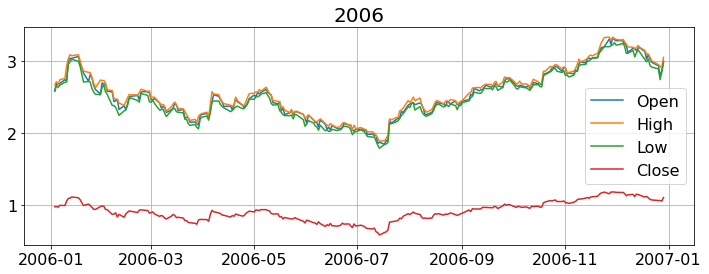

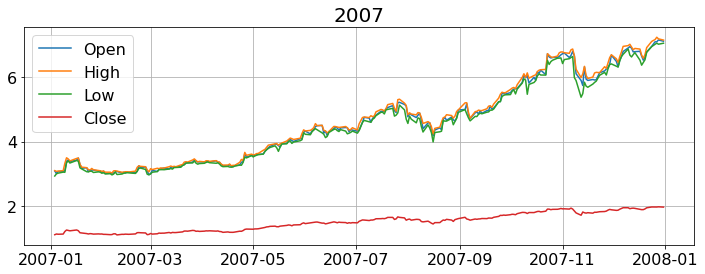

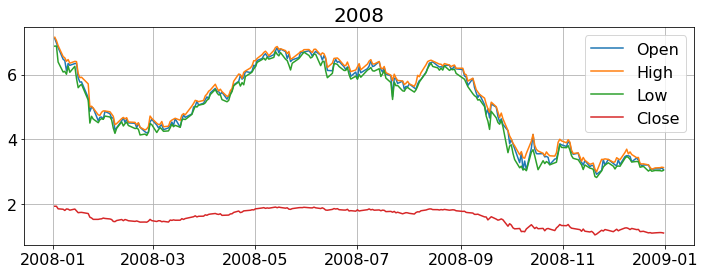

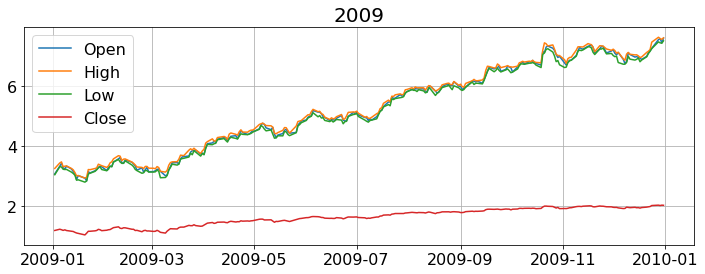

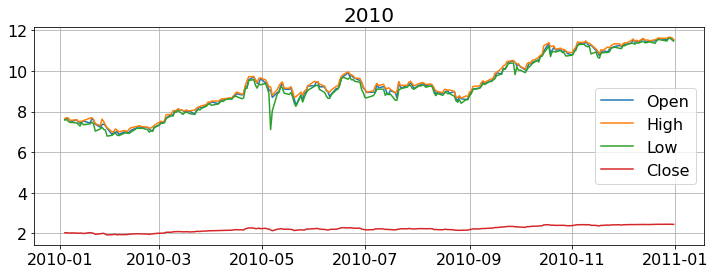

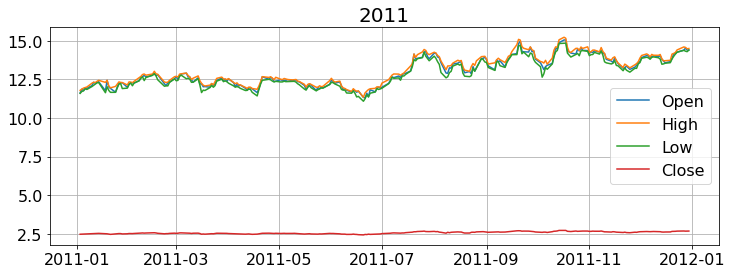

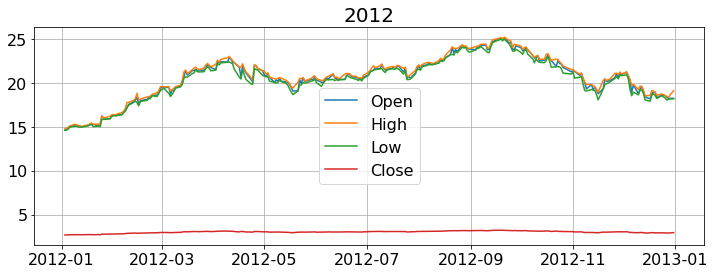

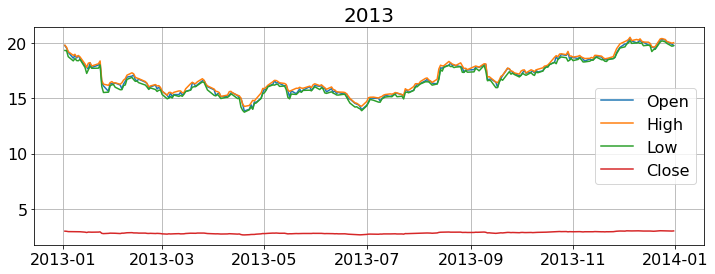

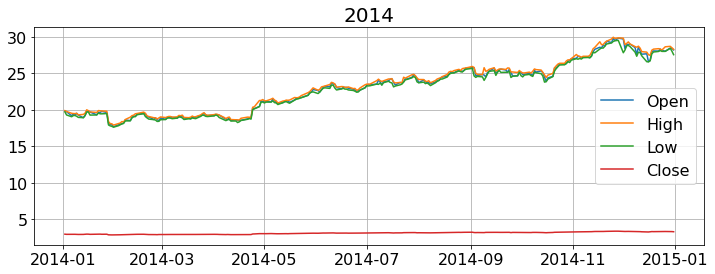

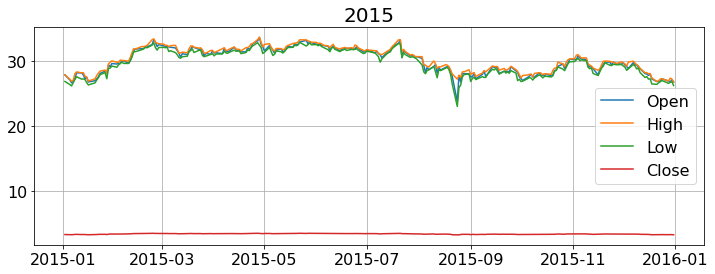

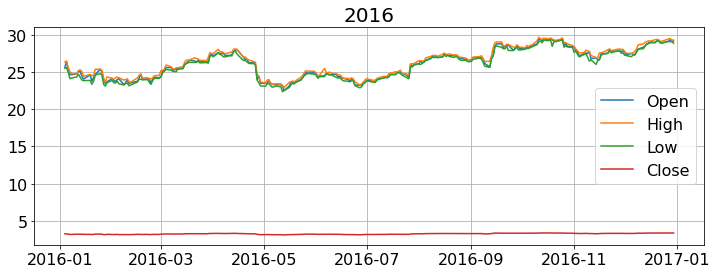

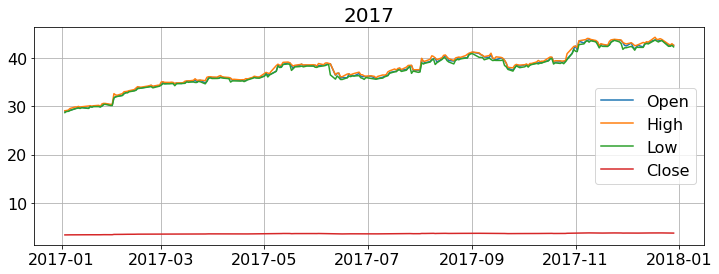

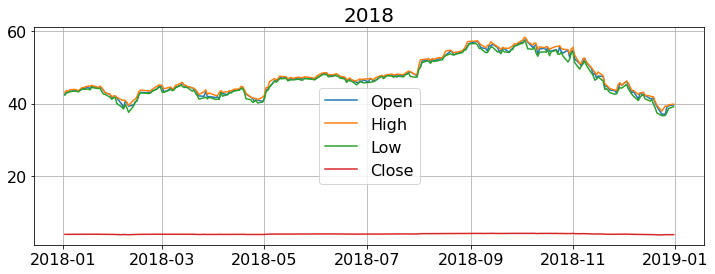

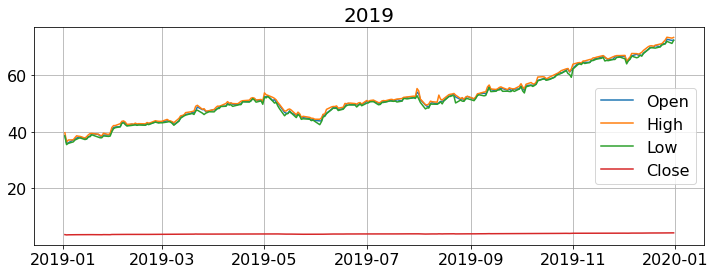

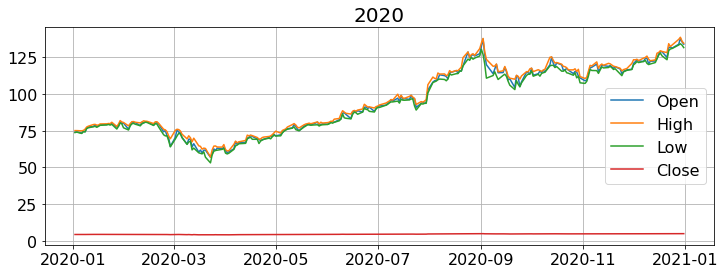

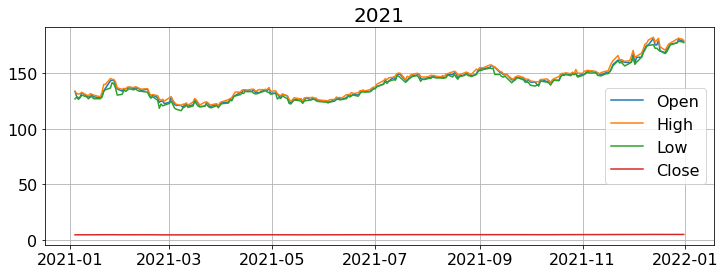

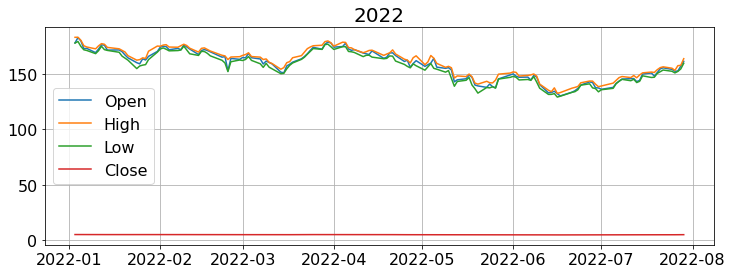

In [12]:
plt.rcParams["figure.figsize"] = 12, 4
plt.rcParams["font.size"] = 16

for year in train_df.index.year.unique():
    plt.plot(train_df[['Open', 'High', 'Low', 'Close']].loc[train_df.index.year == year])
    plt.title(str(year), size=20)
    plt.grid()
    plt.legend(['Open', 'High', 'Low', 'Close'])

    plt.savefig('doc/fig/price_' + str(year) + '.png', dpi=300)

    plt.show()

#### Графики для цен открытия/закрытия и т.д.

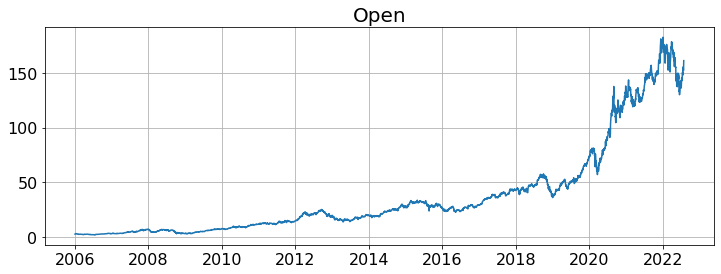

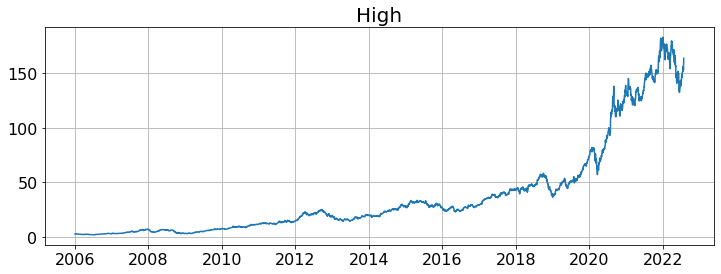

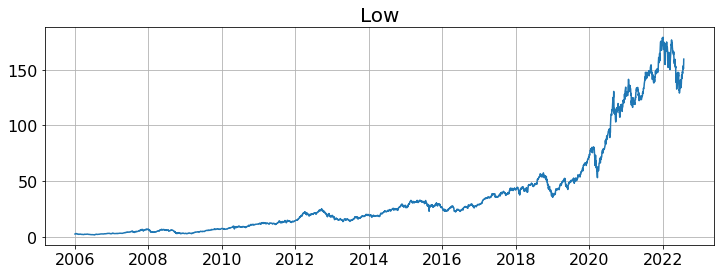

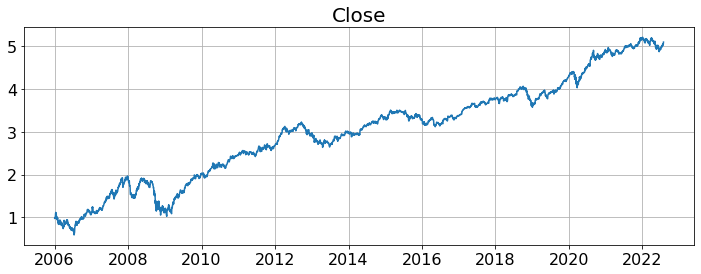

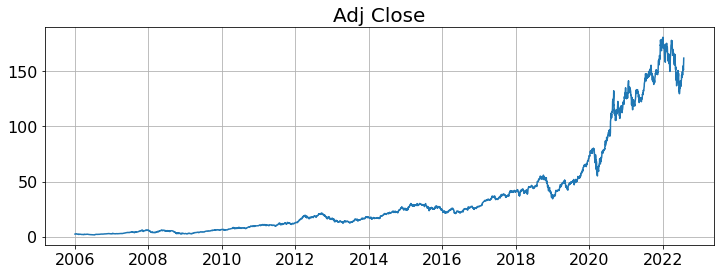

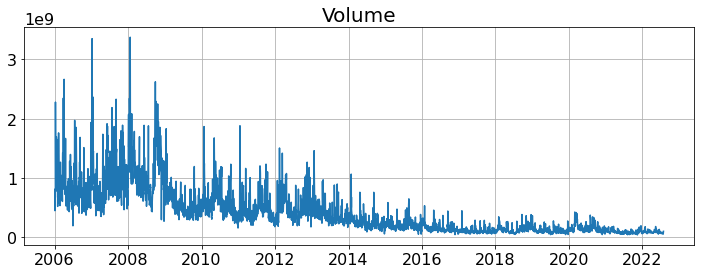

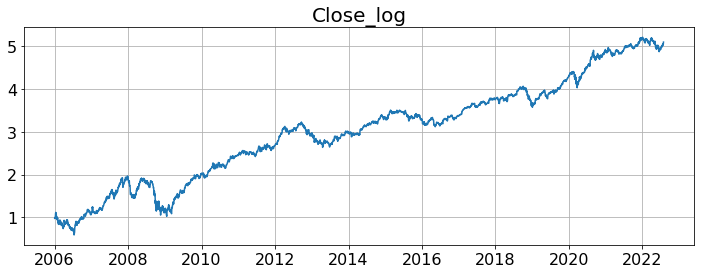

In [13]:
plt.rcParams["figure.figsize"] = 12, 4

for col in train_df.columns:
    plt.plot(train_df[[col]])
    plt.title(col, size=20)
    plt.grid()
    plt.show()

##### *Средние для различных окон*

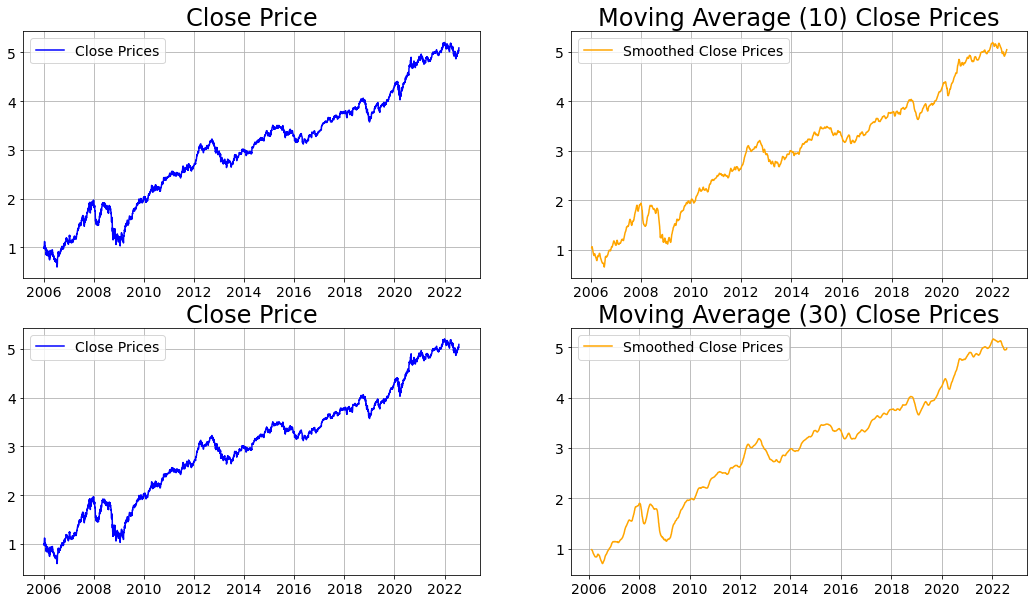

In [14]:
plt.rcParams["figure.figsize"] = 18, 10
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df["Close"], color = "blue", label = "Close Prices")
ax[0, 0].set_title("Close Price", size = 24)
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(train_df["Close"].rolling(window=10).mean(), color = "orange", label = "Smoothed Close Prices")
ax[0, 1].set_title("Moving Average (10) Close Prices", size = 24)
ax[0, 1].grid()
ax[0, 1].legend()

ax[1, 0].plot(train_df["Close"], color = "blue", label = "Close Prices")
ax[1, 0].set_title("Close Price", size = 24)
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(train_df["Close"].rolling(window=30).mean(), color = "orange", label = "Smoothed Close Prices")
ax[1, 1].set_title("Moving Average (30) Close Prices", size = 24)
ax[1, 1].grid()
ax[1, 1].legend()


##### *Свечные графики цен на акции*

In [32]:
plt.rcParams['figure.figsize'] = 18, 5

# plot_data = yf.Ticker()
# Как можно строить свечной график только для Close!?!?!!!!!!!!!!!!!!!!!!!
msft=yf.Ticker(train_df[['Close']])

msft1=msft.history(period="1d")

mpf.plot(msft1, type='candle')
plt.style.use('fivethirtyeight')

AttributeError: 'DataFrame' object has no attribute 'upper'

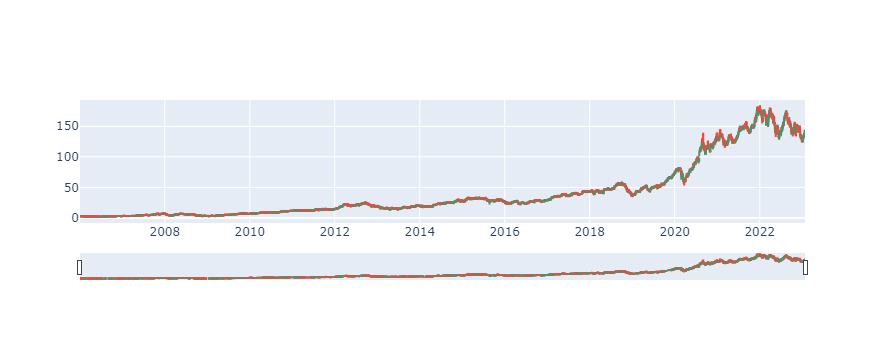

In [9]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

df = train_df.reset_index().copy()

df.head()

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

### #1.3 Декомпозиция ряда 

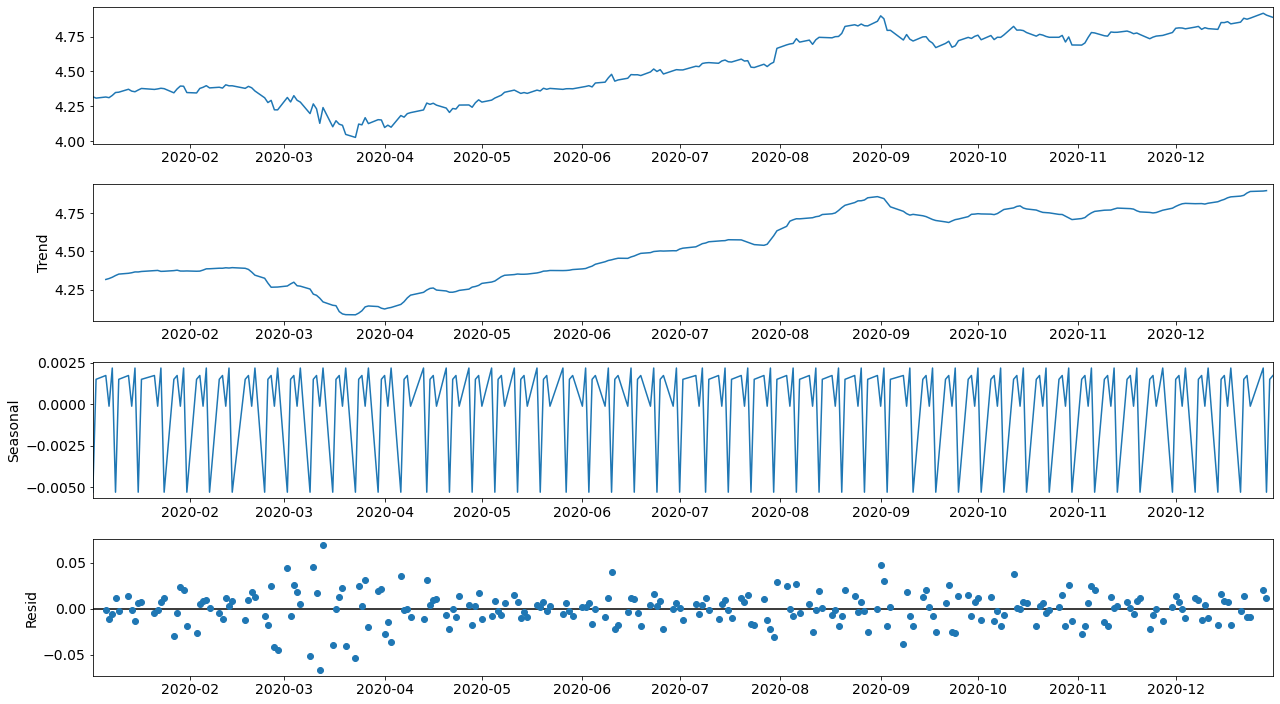

In [15]:
def seasonal_decompose_var_period(df, period):
    """Функция применяет seasonal_decompose к df с периодом period и строит графики декомпозиции"""
    plt.rcParams['figure.figsize'] = 18, 10
    
    result = seasonal_decompose(df, model='additive', period=period)
    
    result.plot()

    plt.show()

    return result


decompose_period7 = seasonal_decompose_var_period(
    train_df.loc[train_df.index.year==2020][["Close"]], period=5)


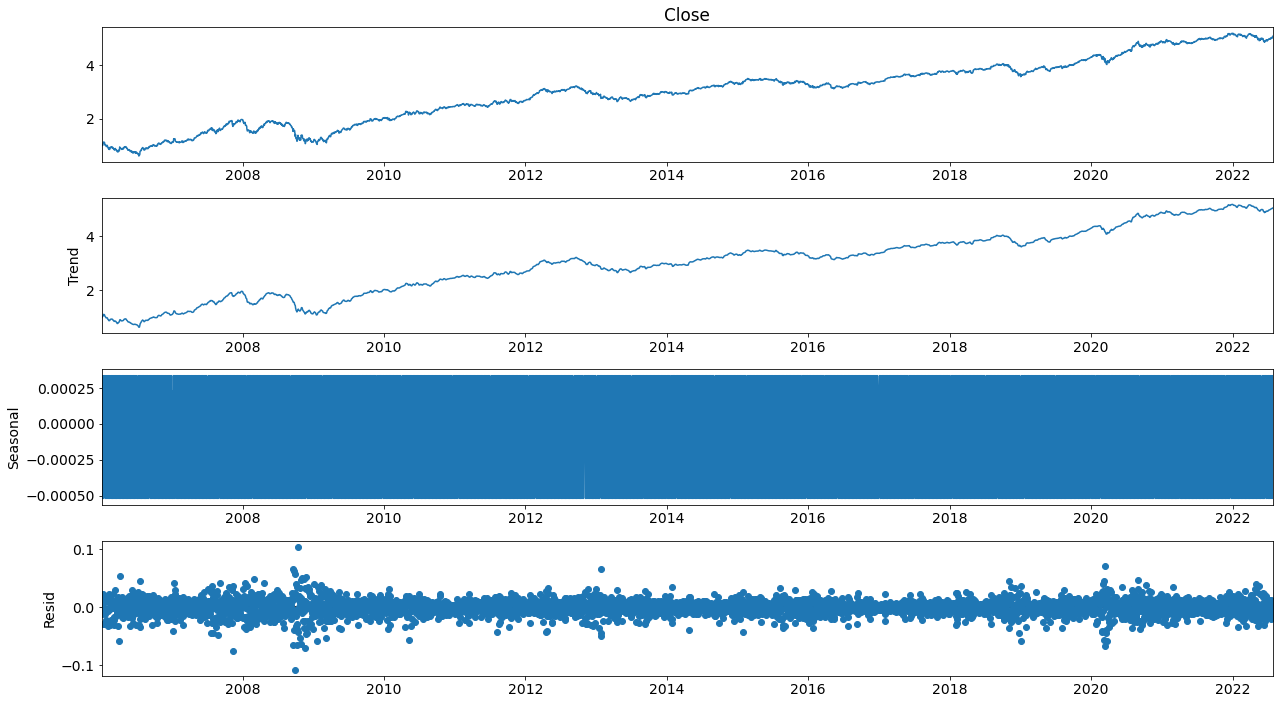

In [16]:
decompose_period5 = seasonal_decompose_var_period(
    train_df["Close"], period=5)

В остатке явно не белый шум содержится. Наблюдается переменная дисперсия (гетероскедастичность) и вроеде постоянное нулевое математическое ожидание

<AxesSubplot:xlabel='Date'>

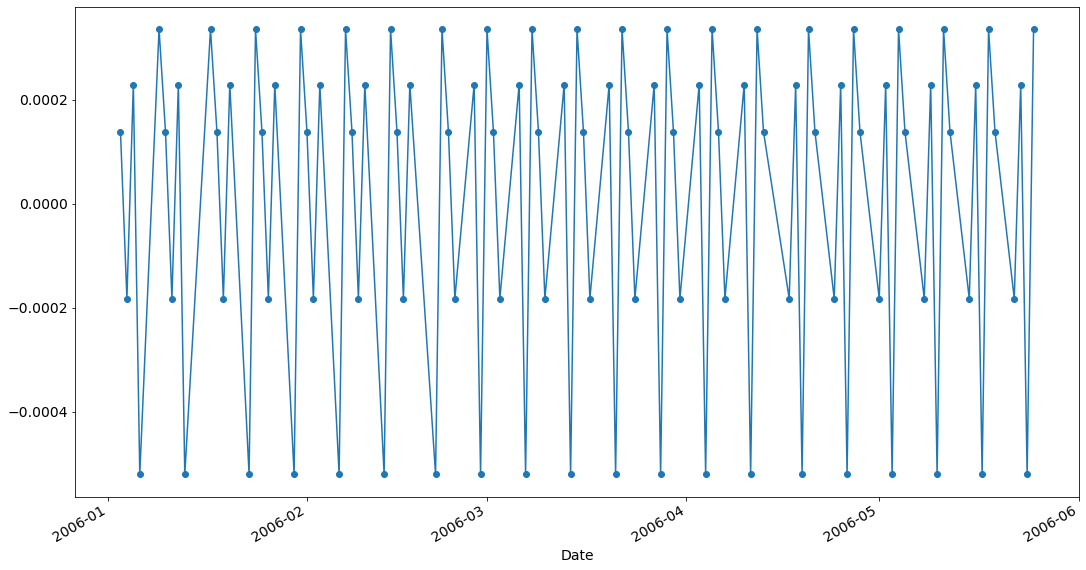

In [17]:
decompose_period5.seasonal[:100].plot(marker='o')

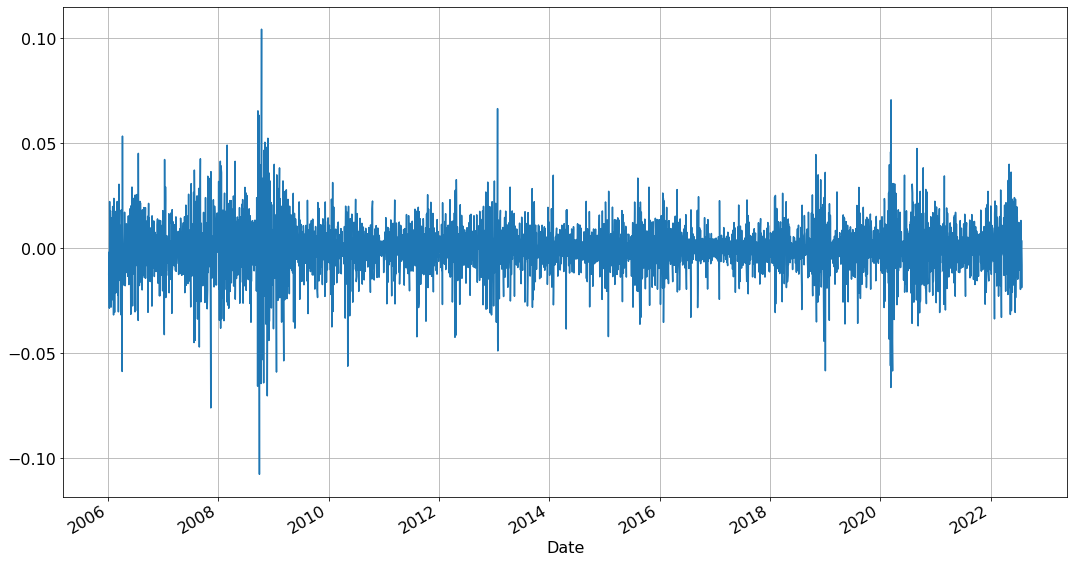

In [18]:
plt.rcParams["font.size"] = 16

decompose_period5.resid.plot()
plt.grid()
plt.show()

<AxesSubplot:xlabel='Date'>

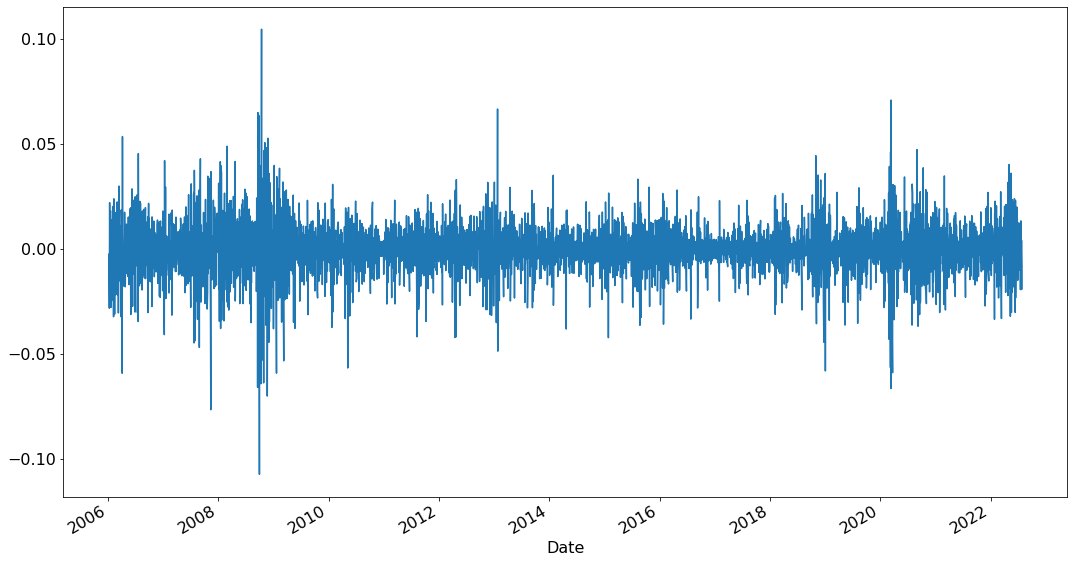

In [19]:
(decompose_period5.seasonal + decompose_period5.resid).plot()

### #1.4 Проверка стационарности ряда

In [22]:
def adf_stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [23]:
adf_stat_test(train_df['Close'])

adf:  -0.5781044674830425
p-value:  0.8758531649376076
Critical values:  {'1%': -3.4319248121667716, '5%': -2.862235865543324, '10%': -2.567140415415872}
есть единичные корни, ряд не стационарен


In [24]:
apple_close_diff1 = train_df['Close'].diff(periods=1).dropna()
adf_stat_test(apple_close_diff1)

adf:  -14.983069655371002
p-value:  1.1544509878880659e-27
Critical values:  {'1%': -3.4319248121667716, '5%': -2.862235865543324, '10%': -2.567140415415872}
единичных корней нет, ряд стационарен


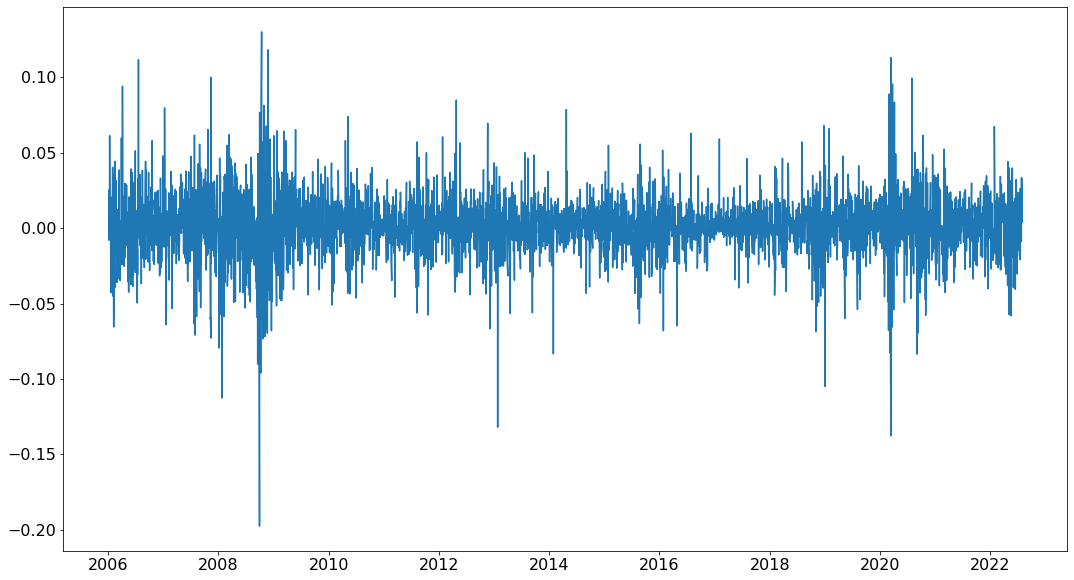

In [25]:
plt.plot(apple_close_diff1)

In [16]:
# plt.rcParams["figure.figsize"] = 18, 10
# plt.rcParams["font.size"] = 14

# fig, ax = plt.subplots(2, 2)

# ax[0, 0].plot(train_df["Close"], color = "blue", label = "Close Prices")
# ax[0, 0].set_title("Close Price", size = 20)
# ax[0, 0].grid()
# ax[0, 0].legend()

# ax[0, 1].plot_acf(train_df["Close"], zero = False, lags = 350)

# ax[1, 0].plot(train_df["Close"].diff(periods=1), color = "blue", label = "Close Prices, 1st diff")
# ax[1, 0].set_title("First difference", size = 20)
# ax[1, 0].grid()
# ax[1, 0].legend()

# ax[1, 1].plot(train_df["Close"].rolling(window=30).mean(), color = "orange", label = "Smoothed Close Prices")
# ax[1, 1].set_title("Moving Average (30) Close Prices", size = 24)
# ax[1, 1].grid()
# ax[1, 1].legend()

### #1.5 График автокорреляционной зависимости

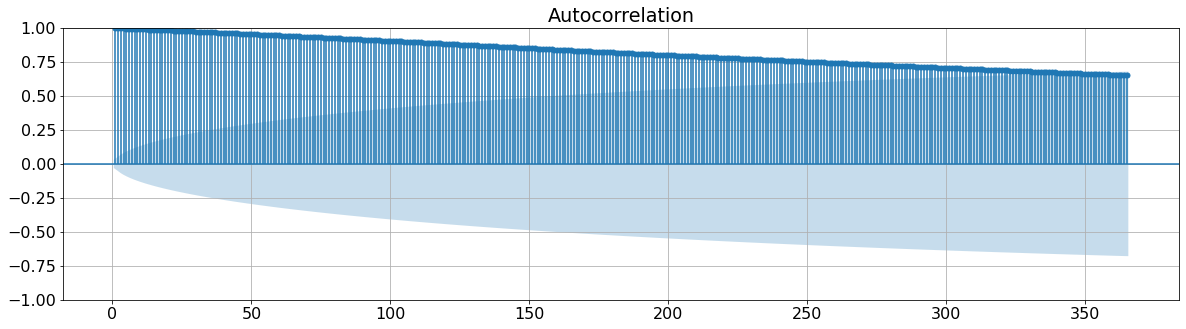

In [27]:
plt.rcParams["figure.figsize"] = 20, 5
plt.rcParams["font.size"] = 16
plot_acf(train_df['Close'], zero = False, lags = 365)
plt.grid()
plt.show()



Цены закрытия очень сильно коррелированны. Корреляция сохраняется почти год. Это происходит из-за наличия явного тренда - функция автокорреляции улавливает эти особенности и воспринимает их как наличие у ряда "памяти", показывая наличие корреляции почти во всех смещениях (https://www.fsight.ru/blog/vremennye-rjady-i-poisk-igolki-v-stoge-sena/). Т.е. ряд не стационарный (из-за изменчивости матожидания как минимум).
Построение ряда разностей полностью убирает тренд из данных

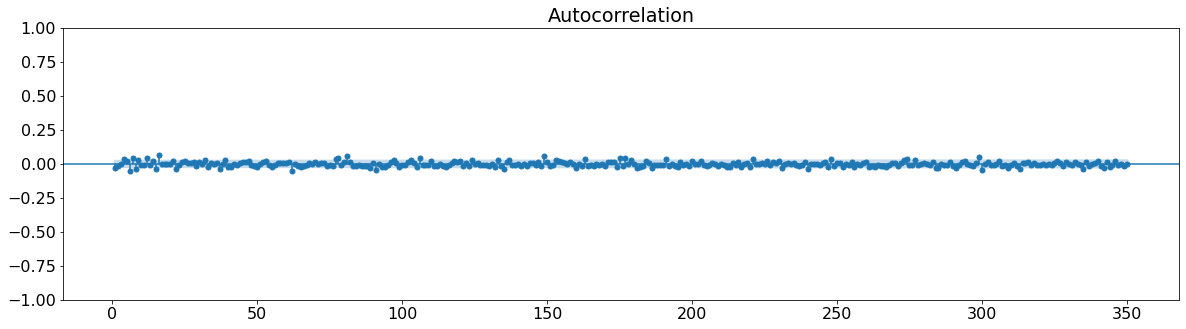

In [28]:
plt.rcParams["figure.figsize"] = 20, 5
plot_acf(apple_close_diff1, zero = False, lags = 350)
plt.show()

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


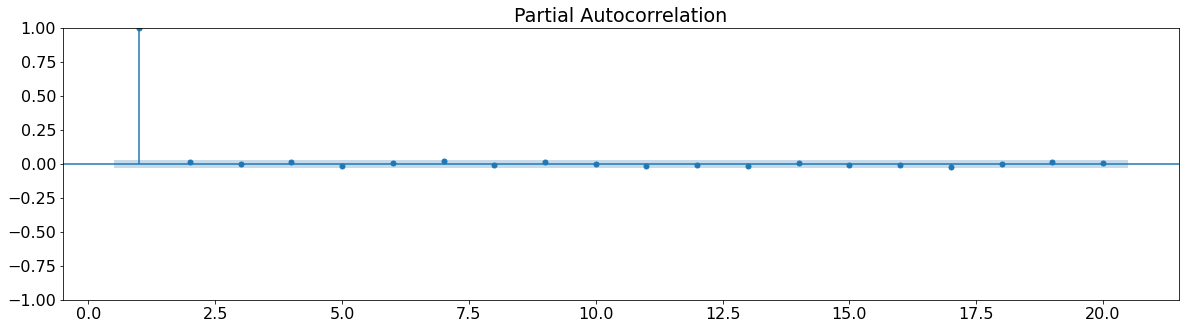

In [29]:
plt.rcParams["figure.figsize"] = 20, 5
plot_pacf(train_df['Close'], zero = False, lags = 20)
plt.show()

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


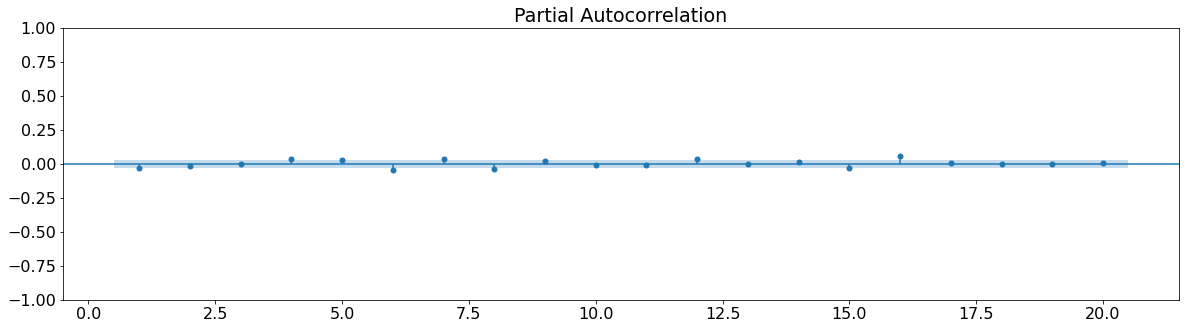

In [30]:
plt.rcParams["figure.figsize"] = 20, 5
plot_pacf(apple_close_diff1, zero = False, lags = 20)
plt.show()

# #2.0 Составление модели и прогнозирование 
### #2.1 Методы на основе ARIMA

In [24]:
# train_tmp_df = train_df.copy()
# test_tmp_df = test_df.copy()

# train_df.index = pd.DatetimeIndex(train_df.index).to_period('W')
# test_df.index = pd.DatetimeIndex(test_df.index).to_period('W')

In [224]:
# train_df = train_tmp_df.copy()
# test_df = test_tmp_df.copy()

In [31]:
def arima_predict_df(df_train, df_test, p, d, q):
    """Формирует DF c предсказанием по ARIMA и доверительным интервалом"""
    # Отключение предупреждений
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")
        
        arima_model = ARIMA(df_train, order=(p, d, q))
        arima_model_fit = arima_model.fit()
        print(f"Критерий Акаике для p={p}, d={d}, q={q}: {arima_model_fit.aic}")
    
        # predict не работает с временными индексами - дает ошибку, поэтому start, end - порядковые
        arima_predict = arima_model_fit.predict(
            start=df_train.shape[0], #df_test.index[0], 
            end=df_train.shape[0] + df_test.shape[0] - 1#end=df_test.index[-1]
        )
    
        # Возвращение к индексам-датам
        arima_predict = pd.DataFrame({'model_preds': arima_predict})
        arima_predict['Date'] = df_test.index
    
        # DF с доверительным интервалом
        forecast = arima_model_fit.get_forecast(len(df_test.index))
        forecast_df = forecast.conf_int(alpha=0.05)
    
        # Объединение DF
        arima_predict = pd.concat([arima_predict, forecast_df], axis=1).set_index('Date')
    
    return arima_predict

def sarima_predict_df(df_train, df_test, pdq=(1, 1, 1), PDQs=(1, 1, 1, 1)):
    """Формирует DF c предсказанием по SARIMA и доверительным интервалом"""
    # Отключение предупреждений
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")
        
        sarima_model = SARIMAX(df_train, order=pdq, seasonal_order=PDQs)
        sarima_model_fit = sarima_model.fit()
        print(f"Критерий Акаике для pdq={pdq}, PDQs={PDQs}: {sarima_model_fit.aic}")
    
        # predict не работает с временными индексами - дает ошибку, поэтому start, end - порядковые
        sarima_predict = sarima_model_fit.predict(
            start=df_train.shape[0], #df_test.index[0], 
            end=df_train.shape[0] + df_test.shape[0] - 1#end=df_test.index[-1]
        )
    
        # Возвращение к индексам-датам
        sarima_predict = pd.DataFrame({'model_preds': sarima_predict})
        sarima_predict['Date'] = df_test.index
    
        # DF с доверительным интервалом
        forecast = sarima_model_fit.get_forecast(len(df_test.index))
        forecast_df = forecast.conf_int(alpha=0.05)
    
        # Объединение DF
        sarima_predict = pd.concat([sarima_predict, forecast_df], axis=1).set_index('Date')
    
    return sarima_predict

def df_prepare4plot(df, df_predict, col_name='Close'):
    """Объединяет и переименовывает столбцы DF для построения"""
    full_df = pd.DataFrame(index = df.index)
    
    full_df[col_name] = df[col_name]
    full_df[['model_preds', 'model_preds_lower', 'model_preds_upper']] = df_predict
    
    return full_df

def arima_predict_plot(df, file_name=''):
    """Выводит график реального ВР + предсказание с доверительным интервалом"""
    plt.rcParams["figure.figsize"] = 18, 12
    
    fig = plt.figure()
    
    plt.subplot(2, 1, 1)
    plt.plot(df["Close"], color = "blue", label = "Actuals", alpha = 0.4)
    plt.plot(df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
    plt.plot(df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
    plt.plot(df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
    plt.title("Full Model Fit", size = 24)
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(df.loc[test_df.index]["Close"], color = "blue", label = "Actuals", alpha = 0.6)
    plt.plot(df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
    plt.plot(df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
    plt.plot(df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
    plt.title("Out of Sample Fit", size = 24)
    plt.grid()
    plt.legend()
    
    preds_len = df['model_preds'].isna().sum()
    
    plt.subplot(2, 2, 4)
    plt.plot(df.iloc[preds_len-5:preds_len+30]["Close"], color = "blue", label = "Actuals", alpha = 0.6)
    plt.plot(df.iloc[preds_len-5:preds_len+30]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
    plt.plot(df.iloc[preds_len-5:preds_len+30]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
    plt.plot(df.iloc[preds_len-5:preds_len+30]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
    plt.title("Out of Sample Fit", size = 24)
    plt.grid()
    plt.legend()
    
    plt.show()
    
    if file_name:
        # print(file_name)
        fig.savefig(file_name, dpi=600)
        
def arima_plot_functions(main_df, train, test, file_name, pdq, PDQs):
    """Объединяет действие предыдущих функций"""
    data_frame = sarima_predict_df(train, test, (0, 1, 1), (4, 1, 0, 5))
    data_frame = df_prepare4plot(main_df, data_frame)
    arima_predict_plot(data_frame, file_name=file_name)

#### # Подбор оптимальных параметров модели

In [32]:
smodel = pm.auto_arima(
    train_df['Close'], 
    start_p=1, start_q=1, test='adf',
    max_p=5, max_q=5, m=5, 
    start_P=0, start_Q=0, seasonal=True,
    max_P=4, max_D=4, max_Q=4, 
    d=1, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=-17754.192, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-17755.459, Time=0.47 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-18853.924, Time=0.87 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=2.96 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-17756.190, Time=0.62 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-19276.316, Time=2.06 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-19575.657, Time=3.23 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-19783.868, Time=4.05 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=8.15 sec
 ARIMA(1,1,0)(3,1,1)[5]             : AIC=inf, Time=8.07 sec
 ARIMA(0,1,0)(4,1,0)[5]             : AIC=-19778.046, Time=4.57 sec
 ARIMA(2,1,0)(4,1,0)[5]             : AIC=-19782.612, Time=6.38 sec
 ARIMA(1,1,1)(4,1,0)[5]             : AIC=-19781.918, Time=4.07 sec
 ARIMA(0,1,1)(4,1,0)[5]             : AIC=-19784.063, Time=3.13 sec
 ARIMA(0,1,1)(3,1,0)[5]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4172
Model:             SARIMAX(0, 1, 1)x(4, 1, [], 5)   Log Likelihood                9898.031
Date:                            Fri, 03 Mar 2023   AIC                         -19784.063
Time:                                    08:49:00   BIC                         -19746.054
Sample:                                         0   HQIC                        -19770.617
                                           - 4172                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0443      0.010     -4.430      0.000      -0.064      -0.025
ar.S.L5       -0.7752      0.010    -75.939      0.000      -0.795      -0.755
ar.S.L10      -0.5873      0.013    -45.394      0.000      -0.613      -0.562
ar.S.L15      -0.4255      0.013    -31.861      0.000      -0.452      -0.399
ar.S.L20      -0.2229      0.011    -19.484      0.000      -0.245      -0.200
sigma2         0.0005   5.84e-06     86.406      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5489.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### # ARIMA (1, 1, 1)

Критерий Акаике для p=1, d=1, q=1: 12788.366413811164


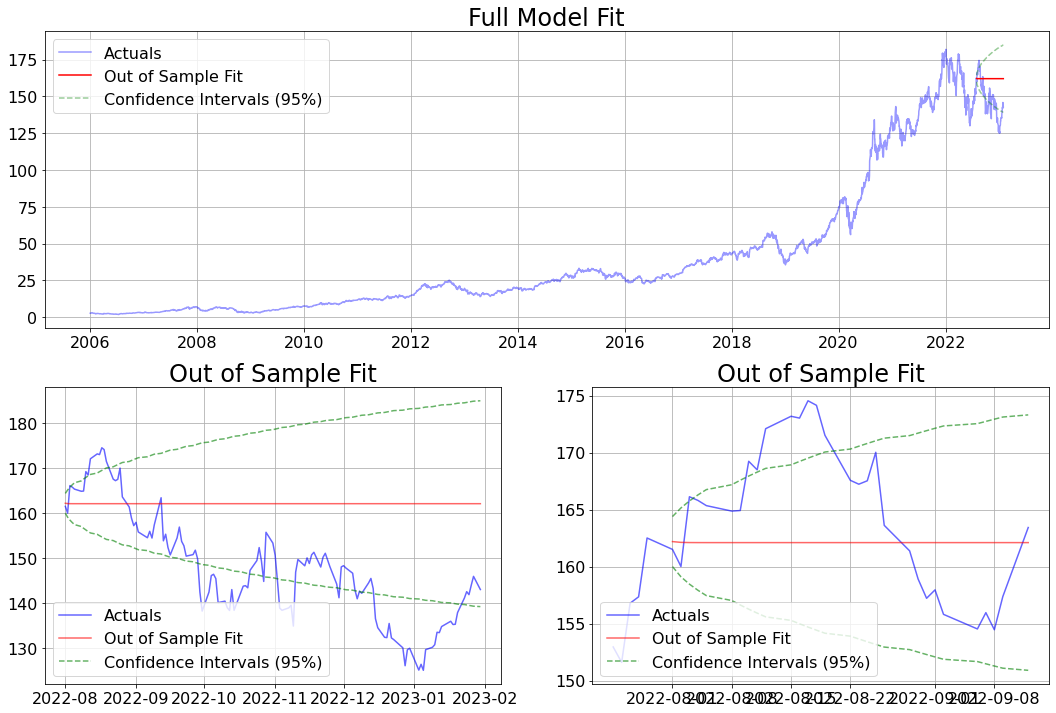

In [350]:
arima111_pred_df = arima_predict_df(train_df['Close'], test_df['Close'], 1, 1, 1)
arima111_pred_df = df_prepare4plot(apple_df, arima111_pred_df)
arima_predict_plot(arima111_pred_df, file_name='.\\fig\\arima_111.png')

In [322]:
arima111_pred_df['model_preds'].isna().sum()

4172

#### # ARIMA (2, 1, 2)

Критерий Акаике для p=2, d=1, q=2: 12791.104811886184


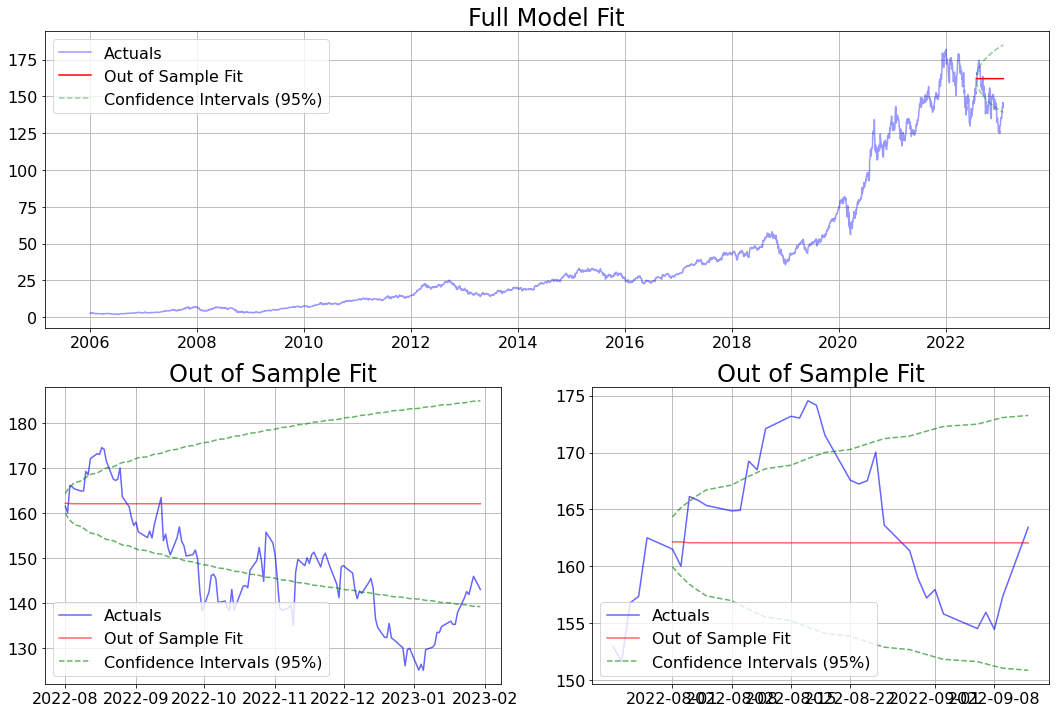

In [351]:
arima212_pred_df = arima_predict_df(train_df['Close'], test_df['Close'], 2, 1, 2)
arima212_pred_df = df_prepare4plot(apple_df, arima212_pred_df)
arima_predict_plot(arima212_pred_df, file_name='.\\fig\\arima212_pred_df.png')

#### # SARIMAX

Критерий Акаике для pdq=(2, 1, 2), PDQs=(1, 1, 2, 5): 12808.784312302763


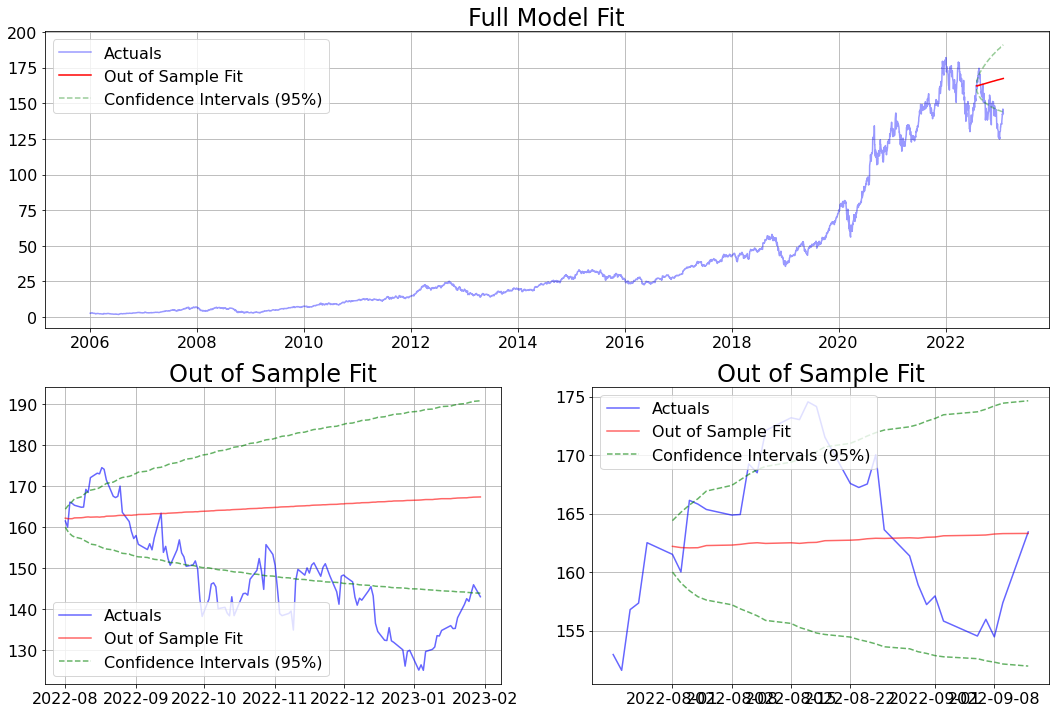

In [352]:
sarimax_212_1125=sarima_predict_df(train_df['Close'], test_df['Close'], (2, 1, 2), (1, 1, 2, 5))
sarimax_212_1125 = df_prepare4plot(apple_df, sarimax_212_1125)
arima_predict_plot(sarimax_212_1125, file_name='.\\fig\\sarimax_212_1125.png')

Критерий Акаике для pdq=(1, 1, 1), PDQs=(2, 1, 0, 5): 14038.762012098676


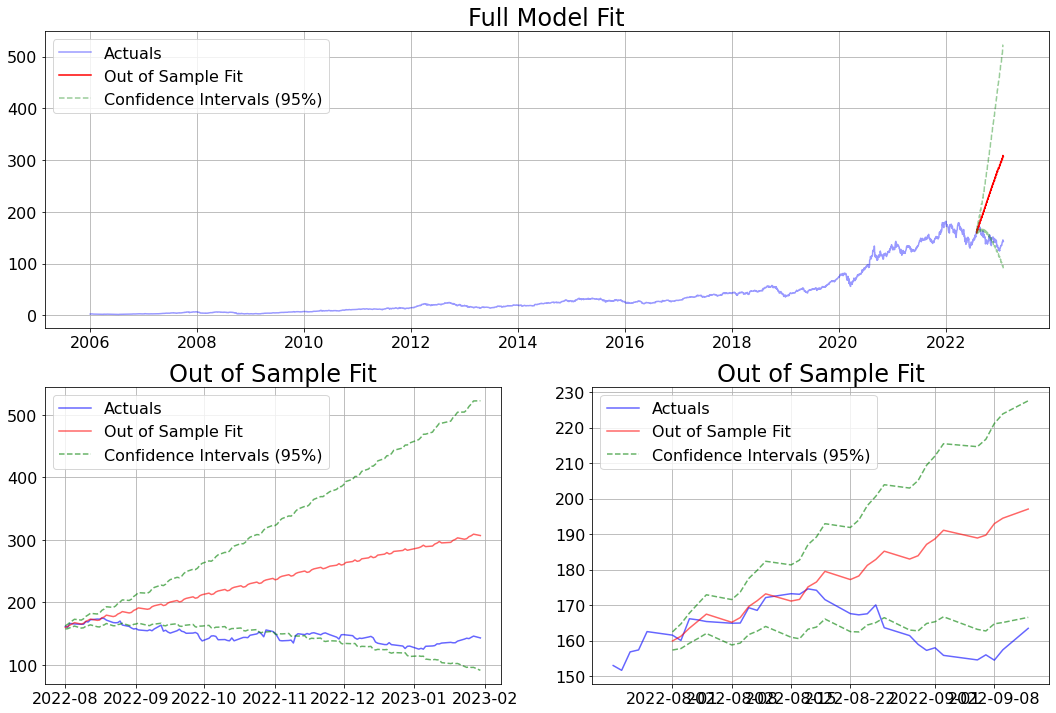

In [353]:
sarimax_111_2105=sarima_predict_df(train_df['Close'], test_df['Close'], (1, 1, 1), (2, 1, 0, 5))
sarimax_111_2105 = df_prepare4plot(apple_df, sarimax_111_2105)
arima_predict_plot(sarimax_111_2105, file_name='.\\fig\\sarimax_111_2105.png')

Критерий Акаике для pdq=(0, 1, 1), PDQs=(3, 1, 0, 5): 13795.646224605767


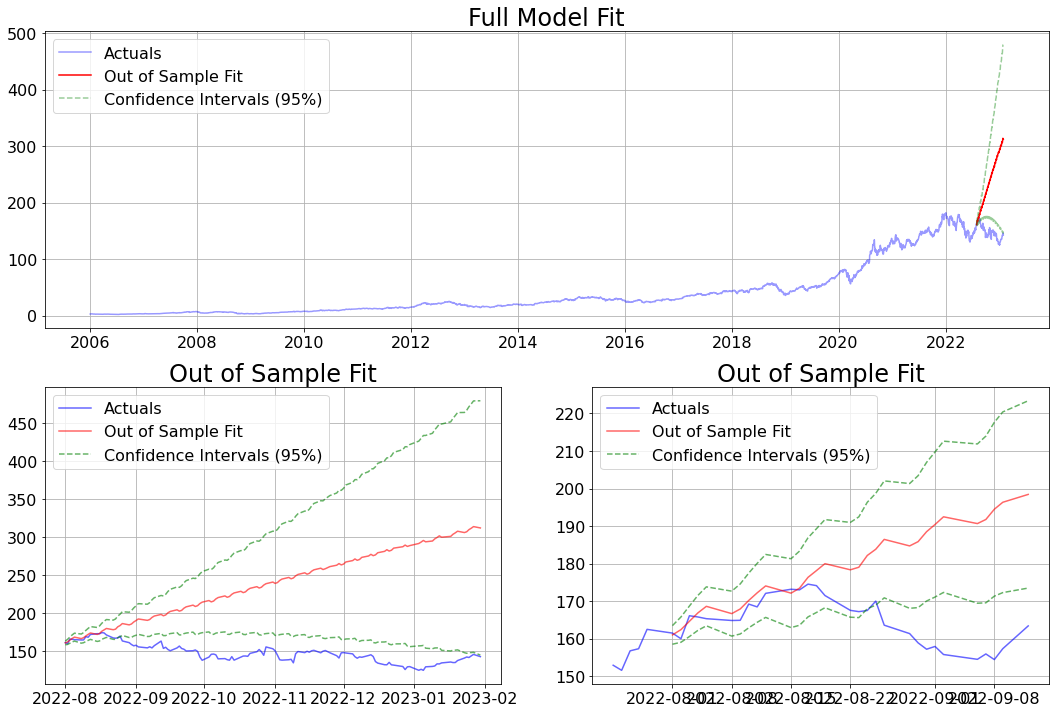

In [360]:
sarimax_011_3105 = sarima_predict_df(train_df['Close'], test_df['Close'], (0, 1, 1), (3, 1, 0, 5))
sarimax_011_3105 = df_prepare4plot(apple_df, sarimax_011_3105)
arima_predict_plot(sarimax_011_3105, file_name='.\\fig\\sarimax_011_3105.png')

Критерий Акаике для pdq=(0, 1, 1), PDQs=(4, 1, 0, 5): 13579.49067337603


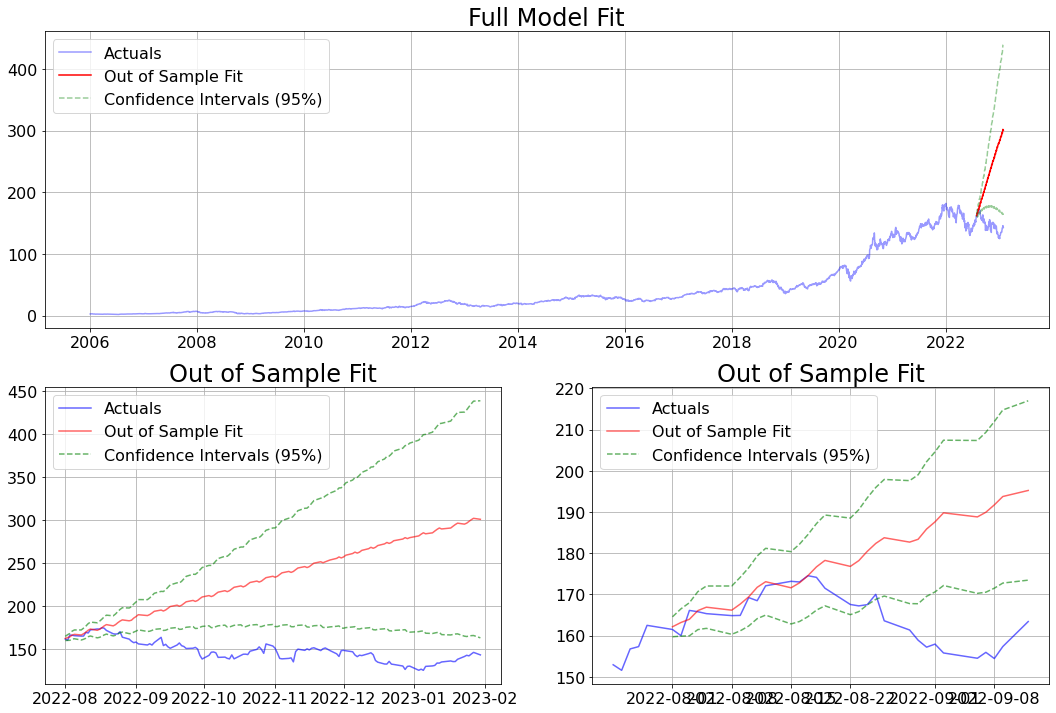

In [364]:
sarimax_011_4105 = sarima_predict_df(train_df['Close'], test_df['Close'], (0, 1, 1), (4, 1, 0, 5))
sarimax_011_4105 = df_prepare4plot(apple_df, sarimax_011_4105)
arima_predict_plot(sarimax_011_4105, file_name='.\\fig\\sarimax_011_4105.png')

### #2.2 Волатилность

In [366]:
apple_df['Close_vol'] = apple_df['Close'].pct_change(1).mul(100).abs()
apple_df['Close_vol'] 

Date
2006-01-03         NaN
2006-01-04    0.294309
2006-01-05    0.786965
2006-01-06    2.581323
2006-01-09    0.327670
                ...   
2023-01-24    1.006306
2023-01-25    0.470075
2023-01-26    1.480337
2023-01-27    1.368426
2023-01-30    2.007807
Name: Close_vol, Length: 4298, dtype: float64

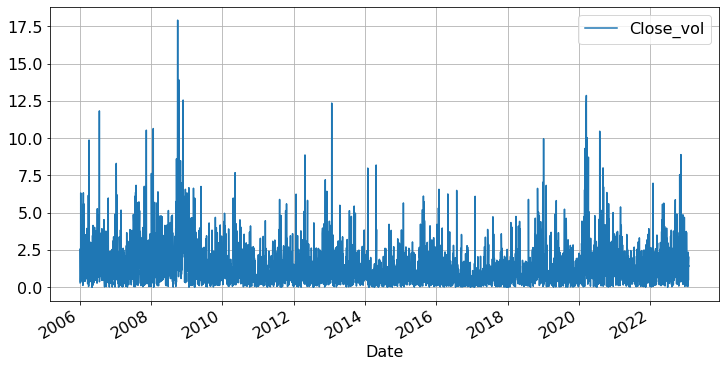

In [371]:
plt.rcParams["figure.figsize"] = 12, 6
plt.rcParams["font.size"] = 16

apple_df[['Close_vol']].plot()
plt.grid()

In [372]:
train_df = apple_df.loc[:"2022-07-29"]
test_df = apple_df.loc["2022-08-01":]

train_df.shape, test_df.shape

((4172, 7), (126, 7))

In [375]:
train_df.Close_vol

Date
2006-01-03         NaN
2006-01-04    0.294309
2006-01-05    0.786965
2006-01-06    2.581323
2006-01-09    0.327670
                ...   
2022-07-25    0.739827
2022-07-26    0.882636
2022-07-27    3.423474
2022-07-28    0.357174
2022-07-29    3.279307
Name: Close_vol, Length: 4172, dtype: float64

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


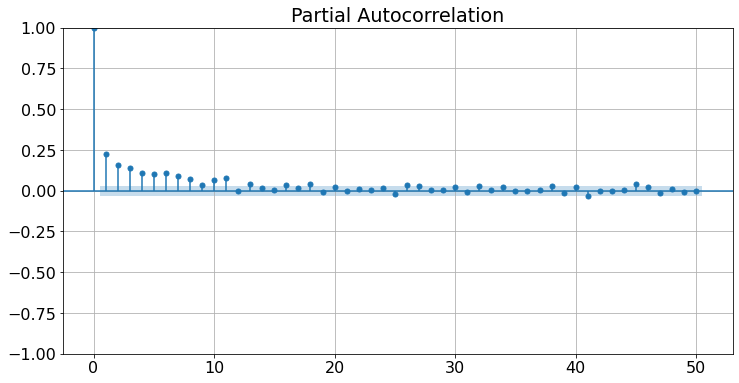

In [393]:
plt.rcParams["figure.figsize"] = 12, 6
plt.rcParams["font.size"] = 16

plot_pacf(train_df.Close_vol[1:], lags=50);
plt.grid()

Из обзора графика PACF для волатильности видно, что самым значимым лаг - первый, после уровни значимости падают. Строится модель GARCH(1, 1)

In [378]:
garch_df = pd.DataFrame(apple_df["Close_vol"].loc[apple_df.index])

# Если данные были преобразованы, то необходимо пользовать актуальные обучающие данные
garch_df.loc[train_df.index, "Close_vol"] = train_df["Close_vol"].dropna()

In [424]:
model = arch_model(garch_df["Close_vol"].dropna(), p=2, q=2, vol="GARCH")

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     45,   Neg. LLF: 7306.254770902176
Iteration:     10,   Func. Count:     85,   Neg. LLF: 7036.732397394731
Iteration:     15,   Func. Count:    122,   Neg. LLF: 7035.174129564288
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7035.174125736161
            Iterations: 17
            Function evaluations: 135
            Gradient evaluations: 17


In [425]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Close_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7035.17
Distribution:                  Normal   AIC:                           14082.3
Method:            Maximum Likelihood   BIC:                           14120.4
                                        No. Observations:                 4171
Date:                Thu, Mar 02 2023   Df Residuals:                     4170
Time:                        20:08:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2268  2.700e-02     45.440      0.000 [  1.174,  1.280]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1117  3.882e-02      2.876  4.027e-03   [3.557e-02,  0.188]
alpha[1]       0.0490  2.130e-02      2.303  2.128e-02 [7.306e-03,9.079e-02]
alpha[2]       0.0793  4.309e-02      1.841  6.567e-02  [-5.140e-03,  0.164]
beta[1]        0.5771      0.281      2.050  4.032e-02   [2.546e-02,  1.129]
beta[2]        0.2438      0.244      0.998      0.318     [ -0.235,  0.722]
============================================================================

Covariance estimator: robust
"""

In [426]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [427]:
predictions_df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Close_vol,Predictions
Date,,,,,,,,
2022-08-01,161.009995,163.589996,160.889999,161.509995,161.018845,67829400,0.615347,1.699260
2022-08-02,160.100006,162.410004,159.630005,160.009995,159.523407,59907000,0.928735,1.496631
2022-08-03,160.839996,166.589996,160.750000,166.130005,165.624817,82507500,3.824767,1.727703
2022-08-04,166.009995,167.190002,164.429993,165.809998,165.305786,55474100,0.192624,2.061398
2022-08-05,163.210007,165.850006,163.000000,165.350006,165.076172,56697000,0.277421,1.851505
2022-08-08,166.369995,167.809998,164.199997,164.869995,164.596954,60276900,0.290300,1.797208
2022-08-09,164.020004,165.820007,163.250000,164.919998,164.646866,63135500,0.030329,1.739972
2022-08-10,167.679993,169.339996,166.899994,169.240005,168.959732,70170500,2.619456,1.762602
2022-08-11,170.059998,170.990005,168.190002,168.490005,168.210968,57149200,0.443158,1.736989


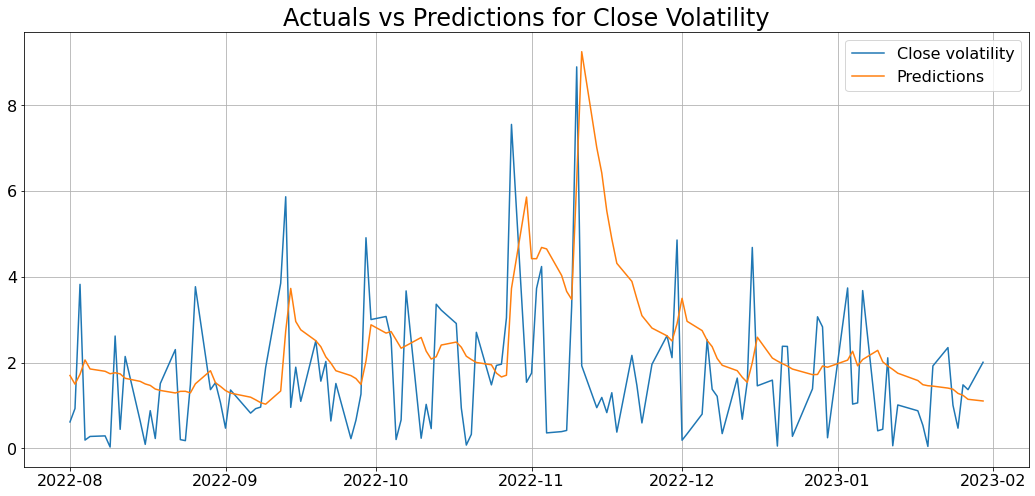

In [428]:
plt.rcParams["figure.figsize"] = 18, 8
plt.rcParams["font.size"] = 16

plt.plot(predictions_df["Close_vol"].abs(), label="Close volatility")
plt.plot(predictions_df["Predictions"], label="Predictions")

plt.title("Actuals vs Predictions for Close Volatility", size = 24)
plt.legend()
plt.grid()

plt.show()

In [429]:
np.sqrt(mean_squared_error(predictions_df['Close_vol'].abs(), predictions_df['Predictions']))

1.9090947039478054

# #3.0 Линейная регрессия

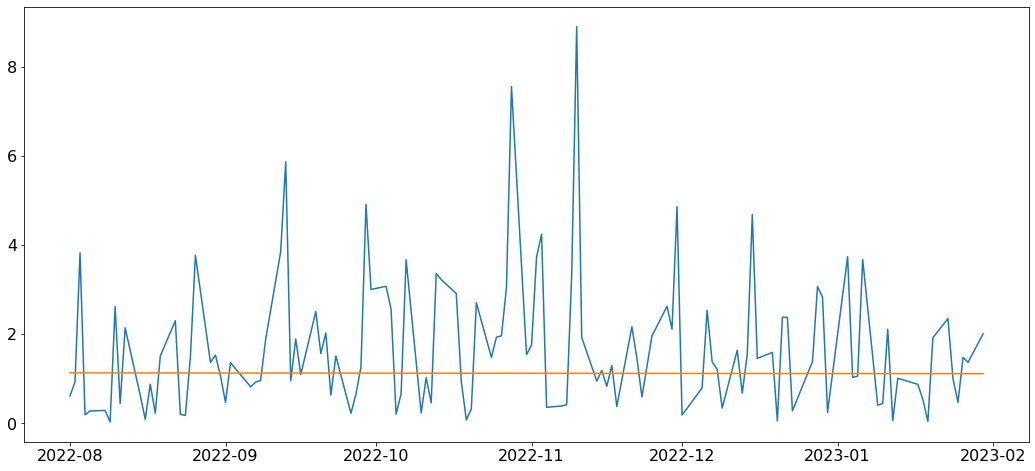

In [433]:
X_train = pd.DataFrame(range(apple_df.shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(apple_df.shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['Close_vol'].fillna(0)
y_test = test_df['Close_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

In [ ]:
X_train = pd.DataFrame(range(data['spx_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['spx_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['spx_vol'].fillna(0)
y_test = test_df['spx_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

In [326]:
arima_model_111 = ARIMA(train_df['Close'], order=(1, 1, 1))
arima_model_fit_111 = arima_model_111.fit()
arima_model_fit_111.summary()

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4172
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6391.183
Date:                Mon, 27 Feb 2023   AIC                          12788.366
Time:                        17:39:11   BIC                          12807.374
Sample:                             0   HQIC                         12795.090
                               - 4172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2222      0.092      2.415      0.016       0.042       0.403
ma.L1         -0.2776      0.091     -3.044      0.002      -0.456      -0.099
sigma2         1.2545      0.009    146.201      0.000       1.238       1.271
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             60561.44
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             212.13   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [327]:
arima_model_fit_111.aic

12788.366413811164

In [328]:
# Формирование прогноза (номинал и доверительный интервал)
pred_df = pd.DataFrame(index = apple_df.index)

# Прогноз на размер тестового DF
arima_111_predict = arima_model_fit_111.predict(
    start=train_df.shape[0],
    end=train_df.shape[0] + test_df.shape[0] - 1
)

# Промежуточный DF с прогнозом и индексами 
arima_111_predict_df = pd.DataFrame({'model_preds': arima_111_predict})
arima_111_predict_df['Date'] = apple_df.iloc[train_df.shape[0]:].index

# Промежуточный DF 
forecast = arima_model_fit_111.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

arima_111_predict_df = pd.concat([arima_111_predict_df, forecast_df], axis=1).set_index('Date')

# Добавление параметров в DF
pred_df['Close'] = apple_df['Close']
pred_df[['model_preds', 'model_preds_lower', 'model_preds_upper']] = arima_111_predict_df

pred_df.tail(127)

C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\b.ostreshko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Close,model_preds,model_preds_lower,model_preds_upper
Date,,,,
2022-07-29,162.509995,NaN,NaN,NaN
2022-08-01,161.509995,162.195510,160.000303,164.390717
2022-08-02,160.009995,162.125626,159.105868,165.145384
2022-08-03,166.130005,162.110096,158.462132,165.758061
2022-08-04,165.809998,162.106645,157.926716,166.286575
...,...,...,...,...
2023-01-24,142.529999,162.105659,139.566359,184.644959
2023-01-25,141.860001,162.105659,139.474327,184.736992
2023-01-26,143.960007,162.105659,139.382667,184.828652


In [ ]:
import pmdarima as pm

smodel = pm.auto_arima(train_tmp_df['Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

In [ ]:
smodel_fit = smodel.fit(train_tmp_df['Close'])

In [ ]:
train_tmp_df.shape[0]

In [ ]:
smodel_fit.predict(n_periods=100)

In [ ]:
test_tmp_df.iloc[:100]['Close']

In [ ]:
seasonal_dec_result_dict = dict()

for period in range(2, 32):
    print(f"period = {period}")
    res = seasonal_decompose_var_period(train_df[['Close']], period=period)
    seasonal_dec_result_dict[period] = res


In [ ]:
for key in seasonal_dec_result_dict.keys():
    print(f"period = {key}")
    plt.rcParams["figure.figsize"] = 10, 5
    seasonal_dec_result_dict[key].seasonal[:100].plot(marker = "o")
    plt.show()

In [ ]:
(seasonal_dec_result_dict[5].trend[-100:] + seasonal_dec_result_dict[5].seasonal[:100]).plot()
seasonal_dec_result_dict[5].trend[-100:].plot()
plt.show()

In [ ]:
plot_df = train_df.loc[train_df.index.year == 2016][['Close']]

plt.rcParams['figure.figsize'] = 18, 10

result = seasonal_decompose(plot_df, model='additive', period=7)

result.plot()
plt.show()

In [ ]:
plot_df = train_df[['Close']]

plt.rcParams['figure.figsize'] = 18, 10

result = seasonal_decompose(plot_df, model='additive', period=9)

result.plot()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:100].plot(marker = "o")
plt.show()

Сезонная компонента 

In [ ]:
plot_df = train_df.loc[train_df[['Close']].index.year == 2016][['Close']]

plt.rcParams['figure.figsize'] = 18, 10

result = seasonal_decompose(plot_df, model='additive', period=31)

result.plot()
plt.show()